# Building Data Genome Project 2.0
## Predictive models

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import math
import datetime
from glob import glob
import gc

# Metrics & Models
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [2]:
path_metadata = "..\\data\\metadata\\"
path_weather = "..\\data\\weather\\"
path_meter_raw = "..\\data\\meters\\raw\\"
path_meter_cleaned = "..\\data\\meters\\cleaned\\"
path_meter_proc = "..\\data\\meters\\processed\\"

# Introduction

In this notebook simple models for this data set will be developed. Long-term and short-term predictions will be performed. These models will be done with the least features possible and with no parameters optimization. These won't be good models, but can work as baseline for a better one.

# Functions

Source code for this function: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# This function concatenate all prediction in one dataframe
# input: files directory list
# output: single dataframe with all predictions

def ConcatAllModels(files):
    dfs = [] # empty list of the dataframes to create
    for file in files: # for each file in directory
        
        model_name = file.split("\\")[3].split("_")[1].split(".")[0] # model_name to rename the model feature
        
        if model_name == "real": # don't rename column
            
            model = pd.read_csv(file) # load the dataset
            
        else: # rename column
            
            model = pd.read_csv(file, header=0, names=[model_name])
            
            
        dfs.append(model) # append to list
    complete_data = pd.concat(dfs, axis=1, ignore_index=False, sort=False) # concatenate all models
   
    return complete_data

# Datasets

## Feature selection

In this notebook only a selection of features will be used.<br>

<i>Building metadata</i>
<ul>
    <li>Building ID*</li>
    <li>Site ID*</li>
    <li>Primary space usage</li>
    <li>Building size (sqm)</li>
</ul>
<i>Weather data</i>
<ul>
    <li>Timestamp*</li>
    <li>Site ID*</li>
    <li>Air temperature</a></li>
</ul>
<i>Meter reading data</i>
<ul>
    <li>Timestamp*</li>
    <li>Building ID*</li>
    <li>meter</li>
    <li>meter reading (target)</li>
</ul>

## Metadata

**Buildings metadata**
* `building_id`: building code-name with the structure <i>SiteID_[SimplifiedUsage](https://github.com/buds-lab/building-data-genome-project-2/wiki/Simplified-PSU)_UniqueName</i>.
* `site_id`: animal-code-name for the site.
* `building_id_kaggle`: building ID used for the [Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction) (numeric).
* `site_id_kaggle`: site ID used for the [Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction) (numeric).
* `primaryspaceusage`: Primary space usage of all buildings is mapped using the [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type). 
* `sub_primaryspaceusage`: [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type) subcategory.
* `sqm`: Floor area of building in square meters (m2). 
* `lat`: Latitude of building location to city level.
* `lng`: Longitude of building location to city level.
* `timezone`: site's timezone.
* `electricity`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `hotwater`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `chilledwater`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `steam`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `water`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `irrigation`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `solar`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `gas`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `industry`: Industry type corresponding to building.
* `subindustry`: More detailed breakdown of Industry type corresponding to building.
* `heatingtype`: Type of heating in corresponding building.
* `yearbuilt`: Year corresponding to when building was first constructed, in the format YYYY.
* `date_opened`: Date building was opened for use, in the format D/M/YYYY.
* `numberoffloors`: Number of floors corresponding to building.
* `occupants`: Usual number of occupants in the building.
* `energystarscore`: Rating of building corresponding to building energystar scheme ([Energy Star Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100)).
* `eui`: [Energy use intensity](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/what-energy) of the building (kWh/year/m2).
* `site_eui`: Energy (Consumed/Purchased) use intensity of the site (kWh/year/m2).
* `source_eui`: Total primary energy consumption normalized by area (Takes into account conversion efficiency of primary energy into secondary energy).
* `leed_level`: LEED rating of the building ([Leadership in Energy and Environmental Design](https://en.wikipedia.org/wiki/Leadership_in_Energy_and_Environmental_Design")), most widely used green building rating system.
* `rating`: Other building energy ratings.

In [5]:
# Buildings metadata
metadata = pd.read_csv(path_metadata + "metadata.csv", usecols = ["building_id",
                                                                 "site_id",
                                                                 "primaryspaceusage",
                                                                 "sqm",
                                                                 ])

metadata = reduce_mem_usage(metadata)
metadata.info()

Mem. usage decreased to  0.04 Mb (12.5% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_id        1636 non-null   object 
 1   site_id            1636 non-null   object 
 2   primaryspaceusage  1615 non-null   object 
 3   sqm                1636 non-null   float32
dtypes: float32(1), object(3)
memory usage: 44.9+ KB


In [6]:
# missing values
metadata.isna().sum()*100/len(metadata)

building_id          0.000000
site_id              0.000000
primaryspaceusage    1.283619
sqm                  0.000000
dtype: float64

In [7]:
metadata[metadata.primaryspaceusage.isna() == True]

,building_id,site_id,primaryspaceusage,sqm
1179,Swan_unknown_Reyna,Swan,NaN,6154.500000
1180,Swan_unknown_Douglas,Swan,NaN,7736.200195
1181,Swan_unknown_Darrin,Swan,NaN,6319.799805
1182,Swan_unknown_Ike,Swan,NaN,6928.100098
1183,Swan_unknown_Esteban,Swan,NaN,6976.399902
1184,Swan_unknown_Christoper,Swan,NaN,8636.599609
1185,Swan_unknown_Isaiah,Swan,NaN,14806.299805
1186,Swan_unknown_Tom,Swan,NaN,4645.000000
1187,Swan_unknown_Jan,Swan,NaN,14952.000000
1188,Swan_unknown_Andres,Swan,NaN,11538.700195


In [8]:
metadata.primaryspaceusage.fillna("Unknown", inplace=True)

In [9]:
# missing values
metadata.isna().sum()*100/len(metadata)

building_id          0.0
site_id              0.0
primaryspaceusage    0.0
sqm                  0.0
dtype: float64

## Weather

**Weather** 
* `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. Local timezone. 
* `site_id`: animal-code-name for the site. * `airTemperature`: The temperature of the air in degrees Celsius (ºC). 
* `cloudCoverage`: Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta). 
* `dewTemperature`: The dew point (the temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur) in degrees Celsius (ºC). 
* `precipDepth1HR`: The depth of liquid precipitation that is measured over a one hour accumulation period (mm). 
* `precipDepth6HR`: The depth of liquid precipitation that is measured over a six hour accumulation period (mm). 
* `seaLvlPressure`: The air pressure relative to Mean Sea Level (MSL) (mbar or hPa). 
* `windDirection`: The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing (degrees). 
* `windSpeed`: The rate of horizontal travel of air past a fixed point (m/s).

In [10]:
# Weather data
weather = pd.read_csv(path_weather + "weather.csv", usecols = ["timestamp",
                                                                  "site_id",
                                                                  "airTemperature"
                                                                  ])
weather = reduce_mem_usage(weather)
weather.info()

Mem. usage decreased to  5.68 Mb (25.0% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331166 entries, 0 to 331165
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       331166 non-null  object 
 1   site_id         331166 non-null  object 
 2   airTemperature  331038 non-null  float16
dtypes: float16(1), object(2)
memory usage: 5.7+ MB


In [11]:
weather.isna().sum()*100/len(weather)

timestamp         0.000000
site_id           0.000000
airTemperature    0.038651
dtype: float64

In [12]:
# Fill NaN with interpolation
weather.airTemperature.interpolate(method="linear",inplace=True)

In [13]:
weather.isna().sum()*100/len(weather)

timestamp         0.0
site_id           0.0
airTemperature    0.0
dtype: float64

## Meters

### Join all cleaned datasets

In [4]:
# files in directory
files = glob(path_meter_cleaned + "*.csv")

In [5]:
files

['..\\data\\meters\\cleaned\\chilledwater_cleaned.csv',
 '..\\data\\meters\\cleaned\\electricity_cleaned.csv',
 '..\\data\\meters\\cleaned\\gas_cleaned.csv',
 '..\\data\\meters\\cleaned\\hotwater_cleaned.csv',
 '..\\data\\meters\\cleaned\\irrigation_cleaned.csv',
 '..\\data\\meters\\cleaned\\solar_cleaned.csv',
 '..\\data\\meters\\cleaned\\steam_cleaned.csv',
 '..\\data\\meters\\cleaned\\water_cleaned.csv']

In [6]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0].split("_")[0]# meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

In [7]:
complete_data.head()

,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater


In [8]:
# Check the meters
complete_data["meter"].value_counts()

electricity     27684432
chilledwater     9736920
steam            6491280
hotwater         3245640
gas              3105288
water            2561424
irrigation        649128
solar              87720
Name: meter, dtype: int64

In [9]:
# Check number of buildings
len(np.unique(complete_data["building_id"]))

1636

In [10]:
# Export dataset
complete_data.to_csv(path_meter_proc + "allmeters_cleaned.csv", index=False)

**All meters dataset (meter reading)**
*   `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. 2016 and 2017 data.
*   `building_id`: building code-name with the structure _UniqueFirstName_SiteID_primaryspaceusage_.
*   `meter_reading`: meter reading in kilowatt hour (kWh) .
*   `meter`: meter type, `chilledwater`, `electricity`, `gas`, `hotwater`, `irrigation`, `steam` or `water`.

In [14]:
# Meters data
data = pd.read_csv(path_meter_proc + "allmeters_cleaned.csv")
data = reduce_mem_usage(data)
data.info()

Mem. usage decreased to 1430.26 Mb (12.5% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53561832 entries, 0 to 53561831
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      object 
 1   building_id    object 
 2   meter_reading  float32
 3   meter          object 
dtypes: float32(1), object(3)
memory usage: 1.4+ GB


In [15]:
# missing data
data.isna().sum()*100/len(data)

timestamp        0.000000
building_id      0.000000
meter_reading    6.934404
meter            0.000000
dtype: float64

In [16]:
# number of buildings in dataset
len(data.building_id.unique())

1636

In [17]:
# Drop missings
data.dropna(inplace=True)

In [18]:
# missing data
data.isna().sum()*100/len(data)

timestamp        0.0
building_id      0.0
meter_reading    0.0
meter            0.0
dtype: float64

In [19]:
# number of buildings in dataset after dropping Nan
len(data.building_id.unique())

1634

# Feature engineering based on EDA

Based on [EDA of meter readings](https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/03_EDA-meter-reading.ipynb):

*   _Healthcare_, _Food sales and services_ and _Utility_ usages shows the highest meter reading values.
*   _Hotwater_ meter shows the highest meter reading values.
*   Monthly behaviour (meter-reading median) shows higher readings in warm season.
*   Hourly behaviour (meter-reading median) shows gihger values from 6 to 19 hs.
*   Weekday behaviour: lowers during weekends.

Based on this observations _month_, _day of the week_ and _hour of the day_ will be added. `primaryspaceusage` categories (16) will be reduced to _healthcare, food, utility_ and _other_. `meter` categories (8) will be preserved. Final features will be:

*   Timestamp*
*   Site ID
*   Building ID
*   Month
*   Hour
*   Day of the week
*   Usage (dummy, 4 levels: _healthcare, food, utility, other_)
*   Building size (sqft)
*   Air temperature
*   Meter (dummy, 8 levels)
*   Meter reading / target

In [20]:
# Reduce primary space usage categories to 3: Healthcare, Utilty, other
metadata.loc[(metadata["primaryspaceusage"] != "Healthcare") & (metadata["primaryspaceusage"] != "Utility") & (metadata["primaryspaceusage"] != "Food sales and service"), "primaryspaceusage"] = "other"

In [21]:
# Check new categories
metadata.primaryspaceusage.unique()

array(['other', 'Food sales and service', 'Healthcare', 'Utility'],
      dtype=object)

In [22]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather["timestamp"] = pd.to_datetime(weather["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [23]:
# Add features
data["month"] = data.timestamp.dt.month
data["weekday"] = data.timestamp.dt.weekday
data["hour"] = data.timestamp.dt.hour

In [24]:
# Merge datasets
data = pd.merge(data, metadata, how="left", on="building_id").merge(weather, how="left", on = ["timestamp", "site_id"])

In [25]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.076904,chilledwater,2,0,9,Panther,other,3100.199951,16.703125
1,2016-02-29 10:00:00,Panther_office_Clementine,222.671402,chilledwater,2,0,10,Panther,other,3100.199951,21.093750
2,2016-02-29 11:00:00,Panther_office_Clementine,235.042007,chilledwater,2,0,11,Panther,other,3100.199951,21.703125
3,2016-02-29 12:00:00,Panther_office_Clementine,247.412598,chilledwater,2,0,12,Panther,other,3100.199951,22.203125
4,2016-02-29 13:00:00,Panther_office_Clementine,272.153900,chilledwater,2,0,13,Panther,other,3100.199951,23.906250


In [26]:
del(weather, metadata)

In [28]:
# Missing values
data.isna().sum()*100/len(data)

timestamp            0.00000
building_id          0.00000
meter_reading        0.00000
meter                0.00000
month                0.00000
weekday              0.00000
hour                 0.00000
site_id              0.00000
primaryspaceusage    0.00000
sqm                  0.00000
airTemperature       0.39557
dtype: float64

In [29]:
data.airTemperature.interpolate(method="linear", inplace=True)

In [30]:
data.isna().sum()*100/len(data)

timestamp            0.0
building_id          0.0
meter_reading        0.0
meter                0.0
month                0.0
weekday              0.0
hour                 0.0
site_id              0.0
primaryspaceusage    0.0
sqm                  0.0
airTemperature       0.0
dtype: float64

In [31]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)
data["sqm"] = data['sqm'].astype(float).round(2)

In [32]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.2,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.2,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.2,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.2,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.2,23.91


In [33]:
data.primaryspaceusage.unique()

array(['other', 'Food sales and service', 'Utility', 'Healthcare'],
      dtype=object)

In [34]:
data.to_csv(path_meter_proc + "dev_merged.csv", index=False)

# Predictive models

## Long-term prediction: whole year 2017 prediction

**Train:** whole year 2016 (01/2016 to 12/2016)<br>
**Validation:** whole year 2017 (01/2017 to 12/2017)

<img src="..\\figures\\split_longterm.png">

In [5]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2519.81 Mb (39.8% reduction)


In [37]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)
data["sqm"] = data['sqm'].astype(float).round(2)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49853098 entries, 0 to 49853097
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   timestamp          datetime64[ns]
 1   building_id        object        
 2   meter_reading      float64       
 3   meter              object        
 4   month              int8          
 5   weekday            int8          
 6   hour               int8          
 7   site_id            object        
 8   primaryspaceusage  object        
 9   sqm                float64       
 10  airTemperature     float64       
dtypes: datetime64[ns](1), float64(3), int8(3), object(4)
memory usage: 3.5+ GB


In [39]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.2,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.2,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.2,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.2,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.2,23.91


In [40]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [41]:
# Strategy split
train = data[data["timestamp"] < "2017-01-01 00:00:00"]
val = data[data["timestamp"] >= "2017-01-01 00:00:00"]
del(data)

Let's check we have the same buildings in both datasets:

In [42]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"train"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"val"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
# list of shared buildings in both datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", left_on="train",right_on="val").drop("val",axis=1).rename(columns={"train":"unique_bdg"}).unique_bdg)
print("Buildings in val AND train: " + str(len(shared_bdg)))
del(train_bdg, val_bdg)

Buildings in train: 1605
Buildings in val: 1613
Buildings in val AND train: 1584


Let's select the shared buildings for the model:

In [43]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]

In [44]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"train"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"val"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
# list of shared buildings in both datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", left_on="train",right_on="val").drop("val",axis=1).rename(columns={"train":"unique_bdg"}).unique_bdg)
print("Buildings in val AND train: " + str(len(shared_bdg)))
del(train_bdg, val_bdg, shared_bdg)

Buildings in train: 1584
Buildings in val: 1584
Buildings in val AND train: 1584


### Real values

In [45]:
val_real = val[["timestamp","building_id","meter","meter_reading"]]
val_real.to_csv("..\\data\\predictions\\longterm_real.csv", index=False)

In [46]:
values, counts = np.unique(val_real.meter_reading, return_counts=True)

In [47]:
print(values)
print(counts)

[0.000000e+00 1.000000e-04 2.000000e-04 ... 8.241450e+06 8.429754e+06
 8.433404e+06]
[3684013   59566   66772 ...       1       1       1]


In [48]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 3352295
Min value: 0.0
Max value: 8433404.0


In [49]:
del(val_real, values, counts)

### Encoding and Data/Target split

In [50]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)

In [ ]:
"""train = train.set_index(["timestamp","building_id"])
val = val.set_index(["timestamp","building_id"])"""

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [51]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)

In [53]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)

In [54]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)

In [55]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)

In [56]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

del(train, val)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [57]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [58]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [59]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=1000,
                verbose_eval=100)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 56870.4
[200]	valid_0's rmse: 57322.4
[300]	valid_0's rmse: 60977.1
[400]	valid_0's rmse: 62945.2
[500]	valid_0's rmse: 63885.2
[600]	valid_0's rmse: 64344.7
[700]	valid_0's rmse: 64652.7
[800]	valid_0's rmse: 64809.2
[900]	valid_0's rmse: 64925.1
[1000]	valid_0's rmse: 65029.7
[1100]	valid_0's rmse: 65108.6
Early stopping, best iteration is:
[135]	valid_0's rmse: 55322.5


In [60]:
gbm.feature_importance()

array([ 24996,   3540,  32963,  10321,  27983,    101,   8256,  52958,
       135342])

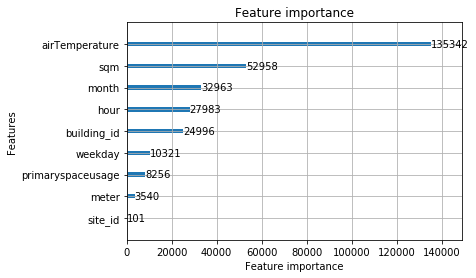

In [61]:
lgb.plot_importance(gbm)

In [62]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [63]:
values, counts = np.unique(y_pred, return_counts=True)

In [64]:
print(values)
print(counts)

[ -46530.43963482  -35837.90790837  -22771.01811955 ... 5830279.71402163
 5851184.60155075 5894745.35015627]
[1 1 3 ... 1 1 2]


In [65]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 356179
Min value: -46530.43963482291
Max value: 5894745.350156269


In [66]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\longterm_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [67]:
del(X_train, X_val, y_train, y_val)
gc.collect()

286

In [70]:
# Filepath
files = glob("..\\data\\predictions\\longterm*")

In [71]:
files

['..\\data\\predictions\\longterm_LGBM.csv',
 '..\\data\\predictions\\longterm_real.csv']

In [72]:
df_pred = ConcatAllModels(files)

In [73]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [74]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-04-17 14:00:00,Panther_office_Clementine,chilledwater,0.0000,3381.195104
1,2017-04-17 15:00:00,Panther_office_Clementine,chilledwater,86.5944,3381.195104
2,2017-04-17 16:00:00,Panther_office_Clementine,chilledwater,309.2658,3381.195104
3,2017-04-17 17:00:00,Panther_office_Clementine,chilledwater,284.5245,3381.195104
4,2017-04-17 18:00:00,Panther_office_Clementine,chilledwater,247.4126,3381.195104


In [75]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\longterm_pred.csv", index=False)

## Short term prediction

**train:** 1 month (core winter and summer months)<br>
**validation:** 3 days<br>
**test:** 3 days

<img src="..\\figures\\split_shorterm.png">

### Winter

In [5]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2519.81 Mb (39.8% reduction)


In [6]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49853098 entries, 0 to 49853097
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqm                float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.9+ GB


In [8]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.199951,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.199951,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.199951,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.199951,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.199951,23.91


In [9]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
# Strategy split
train = data[(data["timestamp"] >= "2017-01-01 00:00:00") & (data["timestamp"] < "2017-02-01 00:00:00")]
val = data[(data["timestamp"] >= "2017-02-01 00:00:00") & (data["timestamp"] < "2017-02-04 00:00:00")]
test = data[(data["timestamp"] >= "2017-02-04 00:00:00") & (data["timestamp"] < "2017-02-07 00:00:00")]
del(data)

Let's check we have the same buildings in all datasets:

In [11]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"bdg"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"bdg"})
test_bdg = pd.DataFrame(test.building_id.unique()).rename(columns={0:"bdg"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
print("Buildings in test: " + str(len(test_bdg)))
# list of shared buildings in all datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", on="bdg").merge(test_bdg, how="inner", on="bdg").bdg)
print("Buildings in val AND train AND test: " + str(len(shared_bdg)))

Buildings in train: 1604
Buildings in val: 1602
Buildings in test: 1602
Buildings in val AND train AND test: 1602


Let's select the shared buildings for the model:

In [12]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]
test = test[test.building_id.isin(shared_bdg) == True]

### Real values

In [13]:
test_real = val[["timestamp","building_id","meter","meter_reading"]]
test_real.to_csv("..\\data\\predictions\\shortterm-winter_real.csv", index=False)

In [14]:
values, counts = np.unique(test_real.meter_reading, return_counts=True)

In [15]:
print(values)
print(counts)

[0.000000e+00 2.000000e-04 4.000000e-04 ... 1.948266e+06 1.970678e+06
 2.515609e+06]
[29436   144   144 ...     1     1     1]


In [16]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 87889
Min value: 0.0
Max value: 2515609.0


In [17]:
del(test_real, values, counts)

### Encoding and Data/Target split

In [18]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)
test = test.drop("timestamp",axis=1)

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [19]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)
test["meter"] = le_meter.transform(test.meter)

In [20]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)
test["primaryspaceusage"] = le_usage.transform(test.primaryspaceusage)

In [21]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)
test["building_id"] = le_usage.transform(test.building_id)

In [22]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)
test["site_id"] = le_usage.transform(test.site_id)

In [23]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

X_test = test.drop("meter_reading", axis=1)
y_test = test["meter_reading"]

del(train, val, test)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [24]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [25]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [26]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=1000,
                verbose_eval=100)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 30024.7
[200]	valid_0's rmse: 24055.7
[300]	valid_0's rmse: 23369.2
[400]	valid_0's rmse: 23537
[500]	valid_0's rmse: 23773.9
[600]	valid_0's rmse: 23938.4
[700]	valid_0's rmse: 24138.1
[800]	valid_0's rmse: 24339.4
[900]	valid_0's rmse: 24499.5
[1000]	valid_0's rmse: 24643.2
[1100]	valid_0's rmse: 24770.6
[1200]	valid_0's rmse: 24908.7
[1300]	valid_0's rmse: 25025
Early stopping, best iteration is:
[324]	valid_0's rmse: 23329.6


In [27]:
gbm.feature_importance()

array([ 30190,   6757,      0,  25715,  35754,    149,  16482, 157949,
       438508])

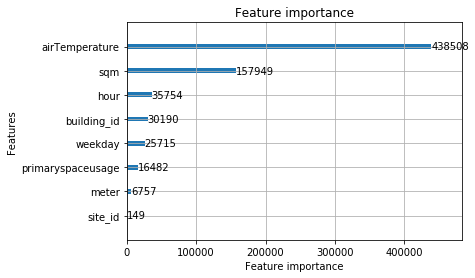

In [28]:
lgb.plot_importance(gbm)

In [29]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [30]:
values, counts = np.unique(y_pred, return_counts=True)

In [31]:
print(values)
print(counts)

[ -25796.47684617  -25501.6884459   -24602.85112748 ... 1430685.98408784
 1440750.04289716 1469723.8920702 ]
[1 1 1 ... 1 1 1]


In [32]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 31094
Min value: -25796.47684616804
Max value: 1469723.892070203


In [33]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\shortterm-winter_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [34]:
del(X_train, X_val, y_train, y_val)
gc.collect()

286

In [35]:
# Filepath
files = glob("..\\data\\predictions\\shortterm-winter*")

In [36]:
files

['..\\data\\predictions\\shortterm-winter_LGBM.csv',
 '..\\data\\predictions\\shortterm-winter_real.csv']

In [37]:
df_pred = ConcatAllModels(files)

In [38]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [39]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-02-01 00:00:00,Panther_lodging_Cora,chilledwater,136.0769,983.970950
1,2017-02-01 01:00:00,Panther_lodging_Cora,chilledwater,123.7063,959.052290
2,2017-02-01 02:00:00,Panther_lodging_Cora,chilledwater,111.3357,683.209410
3,2017-02-01 03:00:00,Panther_lodging_Cora,chilledwater,86.5944,682.228549
4,2017-02-01 04:00:00,Panther_lodging_Cora,chilledwater,86.5944,682.228549


In [40]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\shortterm-winter_pred.csv", index=False)

### Summer

In [41]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2519.81 Mb (39.8% reduction)


In [42]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49853098 entries, 0 to 49853097
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqm                float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.9+ GB


In [44]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.199951,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.199951,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.199951,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.199951,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.199951,23.91


In [45]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [46]:
# Strategy split
train = data[(data["timestamp"] >= "2017-07-01 00:00:00") & (data["timestamp"] < "2017-08-01 00:00:00")]
val = data[(data["timestamp"] >= "2017-08-01 00:00:00") & (data["timestamp"] < "2017-08-04 00:00:00")]
test = data[(data["timestamp"] >= "2017-08-04 00:00:00") & (data["timestamp"] < "2017-08-07 00:00:00")]
del(data)

Let's check we have the same buildings in all datasets:

In [47]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"bdg"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"bdg"})
test_bdg = pd.DataFrame(test.building_id.unique()).rename(columns={0:"bdg"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
print("Buildings in test: " + str(len(test_bdg)))
# list of shared buildings in all datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", on="bdg").merge(test_bdg, how="inner", on="bdg").bdg)
print("Buildings in val AND train AND test: " + str(len(shared_bdg)))

Buildings in train: 1593
Buildings in val: 1587
Buildings in test: 1587
Buildings in val AND train AND test: 1587


Let's select the shared buildings for the model:

In [48]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]
test = test[test.building_id.isin(shared_bdg) == True]

### Real values

In [49]:
test_real = val[["timestamp","building_id","meter","meter_reading"]]
test_real.to_csv("..\\data\\predictions\\shortterm-summer_real.csv", index=False)

In [50]:
values, counts = np.unique(test_real.meter_reading, return_counts=True)

In [51]:
print(values)
print(counts)

[0.0000000e+00 1.0000000e-04 2.0000000e-04 ... 5.3184065e+06 5.4611775e+06
 5.5396525e+06]
[29387   432   504 ...     1     1     1]


In [52]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 93646
Min value: 0.0
Max value: 5539652.5


In [53]:
del(test_real, values, counts)

### Encoding and Data/Target split

In [54]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)
test = test.drop("timestamp",axis=1)

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [55]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)
test["meter"] = le_meter.transform(test.meter)

In [56]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)
test["primaryspaceusage"] = le_usage.transform(test.primaryspaceusage)

In [57]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)
test["building_id"] = le_usage.transform(test.building_id)

In [58]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)
test["site_id"] = le_usage.transform(test.site_id)

In [59]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

X_test = test.drop("meter_reading", axis=1)
y_test = test["meter_reading"]

del(train, val, test)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [60]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [61]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [62]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=10000,
                verbose_eval=1000)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10000 rounds
[1000]	valid_0's rmse: 58102.1
[2000]	valid_0's rmse: 58812.6
[3000]	valid_0's rmse: 59307.2
[4000]	valid_0's rmse: 59484.6
[5000]	valid_0's rmse: 59557.2
[6000]	valid_0's rmse: 59597.7
[7000]	valid_0's rmse: 59652.4
[8000]	valid_0's rmse: 59723.9
[9000]	valid_0's rmse: 59754.4
[10000]	valid_0's rmse: 59794.8
Early stopping, best iteration is:
[146]	valid_0's rmse: 36724.8


In [63]:
gbm.feature_importance()

array([ 11029,   2606,      0,   5970,  11663,      7,   7647,  70342,
       211352])

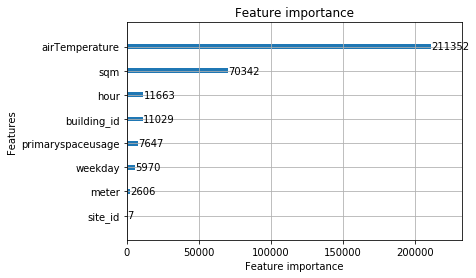

In [64]:
lgb.plot_importance(gbm)

In [65]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [66]:
values, counts = np.unique(y_pred, return_counts=True)

In [67]:
print(values)
print(counts)

[-1.39083693e+03  3.93465016e+02  1.16780326e+03 ...  4.87578929e+06
  4.97956491e+06  4.99692977e+06]
[4 1 1 ... 1 1 1]


In [68]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 13921
Min value: -1390.836927736011
Max value: 4996929.773569435


In [69]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\shortterm-summer_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [70]:
del(X_train, X_val, y_train, y_val)
gc.collect()

331

In [71]:
# Filepath
files = glob("..\\data\\predictions\\shortterm-summer*")

In [72]:
files

['..\\data\\predictions\\shortterm-summer_LGBM.csv',
 '..\\data\\predictions\\shortterm-summer_real.csv']

In [73]:
df_pred = ConcatAllModels(files)

In [74]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [75]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-08-01 00:00:00,Panther_office_Clementine,chilledwater,247.4126,4017.364711
1,2017-08-01 01:00:00,Panther_office_Clementine,chilledwater,247.4126,4017.364711
2,2017-08-01 02:00:00,Panther_office_Clementine,chilledwater,235.0420,4007.846566
3,2017-08-01 03:00:00,Panther_office_Clementine,chilledwater,247.4126,4007.846566
4,2017-08-01 04:00:00,Panther_office_Clementine,chilledwater,247.4126,4007.846566


In [76]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\shortterm-summer_pred.csv", index=False)